# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pydicom
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,PowerTransformer
from sklearn.model_selection import GroupKFold

D:\Anaconda\envs\main2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\main2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\main2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\main2\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type

# Loading the Data

In [2]:
# main_dir = '../input/osic-pulmonary-fibrosis-progression'

# train_files = tf.io.gfile.glob(main_dir+"/train/*/*")
# test_files = tf.io.gfile.glob(main_dir+"/test/*/*")

# sample_sub = pd.read_csv(main_dir+'/sample_submission.csv')
train = pd.read_csv('Data/ourtrain.csv')
test = pd.read_csv('Data/our_test.csv')
# print ("Number of train patients: {}\nNumber of test patients: {:4}"
#        .format(train.Patient.nunique(), test.Patient.nunique()))

# print ("\nTotal number of Train patient records: {}\nTotal number of Test patient records: {:6}"
#        .format(len(train_files), len(test_files)))

train.shape, test.shape, #sample_sub.shape

((1223, 7), (312, 7))

## Function to calculate Metrics

In [3]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
#the training data has the same patient fvc values, over randomized weeks. 

In [5]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker
1,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker
2,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker
3,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker
4,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker
...,...,...,...,...,...,...,...
307,ID00421637202311550012437,21,2820,84.471603,68,Male,Ex-smoker
308,ID00421637202311550012437,23,2853,85.460101,68,Male,Ex-smoker
309,ID00421637202311550012437,29,2716,81.356338,68,Male,Ex-smoker
310,ID00421637202311550012437,41,2833,84.861011,68,Male,Ex-smoker


In [6]:
#the test data would show the fvc value for a particular week.
#we have to predict the final three fvc value, and confidence. 
#note: the test entries are also in the training set. 

In [7]:
# Using Weeks, Age, Sex and Smoking Status columns from train data
X = train[['Weeks','Age','Sex','SmokingStatus']].copy()
y = train['FVC'].copy()

# save the stats for future use
stats = X.describe().T

# One hot encoding on Sex and SmokingStatus columns
#pd.get_dummies - assign numerical value to these categorical inputs. 
X = pd.get_dummies(X, columns =['Sex','SmokingStatus'],drop_first=True)

#Scaling numeric features 
# scaling the numeric features
for col in ['Weeks', 'Age']:
    X[col] = (X[col] - stats.loc[col, 'min']) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])

In [8]:
X.head()

,Weeks,Age,Sex_Male,SmokingStatus_Ex-smoker,SmokingStatus_Never smoked
0,0.007246,0.789474,1,1,0
1,0.072464,0.789474,1,1,0
2,0.086957,0.789474,1,1,0
3,0.101449,0.789474,1,1,0
4,0.115942,0.789474,1,1,0


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge,RidgeCV, Lasso
from sklearn.metrics import make_scorer


In [10]:
sigma = 250

In [11]:
def laplace_log_likelihood(y_true, y_pred, sigma=70):
    # values smaller than 70 are clipped
    sigma_clipped = tf.maximum(sigma, 70)

    # errors greater than 1000 are clipped
    delta_clipped = tf.minimum(tf.abs(y_true - y_pred), 1000)
    
    # type cast them suitably
    delta_clipped = tf.cast(delta_clipped, dtype=tf.float32)
    sigma_clipped = tf.cast(sigma_clipped, dtype=tf.float32)
    
    # score function
    score = - tf.sqrt(2.0) * delta_clipped / sigma_clipped - tf.math.log(tf.sqrt(2.0) * sigma_clipped)
    
    return tf.reduce_mean(score)

In [12]:
# # Creating a scorer function, returns a callable that scores an estimator’s output.
# l1 = (make_scorer(
#     lambda X,y : laplace_log_likelihood(X,y,sigma=sigma).numpy(),
#     greater_is_better=False))

# cross_val_score(LinearRegression(),X,y,cv=3,scoring=l1)
# #returns array of scores of the estimator for each run of the cross validation.


In [13]:
#scores increases after each run of cross validation. 
#this is the scoring of the linear regression estimator. 

In [14]:
X = train.copy()
y = train['FVC'].copy()

X['base_week'] = X.groupby('Patient')['Weeks'].transform('min')
X['base_FVC'] = X.groupby('Patient')['FVC'].transform('first')

# save the stats for future use
stats = X.describe().T

# one hot encoding for categorical features
X = pd.get_dummies(data=X, columns=['Sex','SmokingStatus'], drop_first=True)

# Scaling numeric columns
num_cols = ['Age','Weeks','base_week','base_FVC']

# Min-max scaling
for col in num_cols:
    X[col] = (X[col]-stats.loc[col,'min']) / (stats.loc[col,'max'] - stats.loc[col,'min'])
    
# printing the correlation of all features with FVC
print(X.corr()['FVC'].abs().sort_values(ascending=False)[1:])

base_FVC                      0.962155
Percent                       0.663128
Sex_Male                      0.483409
SmokingStatus_Never smoked    0.183468
Age                           0.149372
SmokingStatus_Ex-smoker       0.119985
Weeks                         0.023979
base_week                     0.006648
Name: FVC, dtype: float64


In [15]:
# removing unnecesary columns after transformations
#drop patient, as we are building a model based on our values 
X.drop(['Patient','FVC'], axis=1, inplace=True)
X.head()

,Weeks,Percent,Age,base_week,base_FVC,Sex_Male,SmokingStatus_Ex-smoker,SmokingStatus_Never smoked
0,0.007246,58.253649,0.789474,0.011905,0.241456,1,1,0
1,0.072464,55.712129,0.789474,0.011905,0.241456,1,1,0
2,0.086957,51.862104,0.789474,0.011905,0.241456,1,1,0
3,0.101449,53.950679,0.789474,0.011905,0.241456,1,1,0
4,0.115942,52.063412,0.789474,0.011905,0.241456,1,1,0


In [16]:
y.head()

0    2315
1    2214
2    2061
3    2144
4    2069
Name: FVC, dtype: int64

In [17]:
# Checking the score on transformed data nowla
cross_val_score(LinearRegression(),X,y,cv=3,scoring='neg_root_mean_squared_error')

array([-178.66715958, -191.27543824, -196.99707731])

As we can see, the fold scores have improved significantly. Lets fit the Linear model on this data.

### Making Prediction on Test Data

Dataframe y

Series y

## Grid Search Time

In [18]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

grid_params = {"alpha": np.linspace(0,0.001,11)}



grid = GridSearchCV(Ridge(), param_grid=grid_params, n_jobs=-1, cv=3,return_train_score= True)
grid.fit(X,y)

print (grid.best_params_, grid.best_score_)
#print(model.get_params_(deep=True))
model = grid.best_estimator_
print(grid.best_estimator_)

{'alpha': 0.0} 0.946869413341806
Ridge(alpha=0.0)


Test with inbuilt cv 

In [19]:
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
clf.score(X, y)
#clf.alpha_

0.9564521394568773

In [20]:
grid.cv_results_

{'mean_fit_time': array([0.01199794, 0.00400122, 0.00500027, 0.00300018, 0.00366735,
        0.00400138, 0.00400146, 0.0043335 , 0.00400122, 0.00333325,
        0.00266751]),
 'std_fit_time': array([5.35826704e-03, 8.16729406e-04, 1.41439212e-03, 7.86741172e-07,
        9.43920945e-04, 8.17313425e-04, 8.16049002e-04, 1.24853094e-03,
        1.41439212e-03, 4.72269527e-04, 4.71595499e-04]),
 'mean_score_time': array([0.00299907, 0.00233348, 0.00199938, 0.00199978, 0.00199954,
        0.00266703, 0.00333277, 0.00166631, 0.00199914, 0.00200065,
        0.00233229]),
 'std_score_time': array([1.41562843e-03, 4.71989320e-04, 3.37174788e-07, 8.17313966e-04,
        9.98958356e-07, 9.42684557e-04, 4.71427042e-04, 4.72044743e-04,
        8.48537942e-07, 8.16145448e-04, 4.72494631e-04]),
 'param_alpha': masked_array(data=[0.0, 0.0001, 0.0002, 0.00030000000000000003, 0.0004,
                    0.0005, 0.0006000000000000001, 0.0007, 0.0008,
                    0.0009000000000000001, 0.001],
    

In [21]:

grid_results = pd.DataFrame.from_dict(grid.cv_results_)
grid_results.to_csv('grid_results.csv',index=False)

Using Cross val score to plot 

In [22]:
best_score = (0, np.inf, np.inf)
for i in range(50, 1500, 50):
    sigma=i
    temp = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error')
    if best_score[1] > temp.mean():
        best_score = i, temp.mean(), temp.std()
        
sigma = best_score[0]
best_score

(50, -188.97989170853975, 7.657180570151024)

Taken from week 6 notebook 

In [23]:
for Model in [Ridge, Lasso]:
    model = Model()
    print('%s: %s' % (Model.__name__,
                      cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error').mean()))

Ridge: -200.321386946722
Lasso: -189.35788843225995


Plots

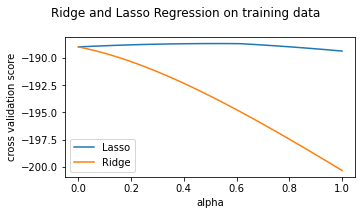

<Figure size 432x288 with 0 Axes>

In [24]:
alphas = np.logspace(-3, 0, 100)

plt.figure(figsize=(5, 3))

for Model in [Lasso, Ridge]:
    scores = [cross_val_score(Model(alpha), X, y, cv=3,scoring='neg_root_mean_squared_error').mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.suptitle('Ridge and Lasso Regression on training data')
plt.tight_layout()
plt.show()
plt.savefig('ruffles.png')

## Test Data Preparation

In [25]:
X_test = test.copy()
y_test = test['FVC'].copy()

X_test['base_week'] = X_test.groupby('Patient')['Weeks'].transform('min')
X_test['base_FVC'] = X_test.groupby('Patient')['FVC'].transform('first')

# save the stats for future use
stats = X_test.describe().T

# one hot encoding for categorical features
X_test = pd.get_dummies(data=X_test, columns=['Sex','SmokingStatus'], drop_first=True)

# Scaling numeric columns
num_cols = ['Age','Weeks','base_week','base_FVC']

# Min-max scaling
for col in num_cols:
    X_test[col] = (X_test[col]-stats.loc[col,'min']) / (stats.loc[col,'max'] - stats.loc[col,'min'])



In [26]:
X_test.drop(['Patient','FVC'], axis=1, inplace=True)
X_test.head()

,Weeks,Percent,Age,base_week,base_FVC,Sex_Male,SmokingStatus_Ex-smoker,SmokingStatus_Never smoked
0,0.009434,65.306122,0.540541,0.019231,0.044037,0,1,0
1,0.066038,58.163265,0.540541,0.019231,0.044037,0,1,0
2,0.084906,57.865646,0.540541,0.019231,0.044037,0,1,0
3,0.103774,62.287415,0.540541,0.019231,0.044037,0,1,0
4,0.122642,71.471088,0.540541,0.019231,0.044037,0,1,0


## Model training from here

In [27]:
# linear reg
# lr = LinearRegression().fit(X, y)
# lr.predict(X)

# pred_test = test.copy()
# pred_test['FVC'] = lr.predict(X_test) # predicted FVC here

# ridge reg 
ruffles = Ridge(alpha = 0.1)
ruffles.fit(X,y)
#grid seach model
# pred_test = test.copy()
# pred_test['FVC'] = grid.predict(X_test)
pred_test = test.copy()
pred_test['FVC'] = ruffles.predict(X_test)

In [28]:
pred_test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00023637202179104603099,-3,1172.144646,65.306122,71,Female,Ex-smoker
1,ID00023637202179104603099,3,1070.530750,58.163265,71,Female,Ex-smoker
2,ID00023637202179104603099,5,1061.193595,57.865646,71,Female,Ex-smoker
3,ID00023637202179104603099,7,1107.433787,62.287415,71,Female,Ex-smoker
4,ID00023637202179104603099,9,1209.752023,71.471088,71,Female,Ex-smoker
...,...,...,...,...,...,...,...
307,ID00421637202311550012437,21,3271.961292,84.471603,68,Male,Ex-smoker
308,ID00421637202311550012437,23,3277.769946,85.460101,68,Male,Ex-smoker
309,ID00421637202311550012437,29,3211.945614,81.356338,68,Male,Ex-smoker
310,ID00421637202311550012437,41,3218.224343,84.861011,68,Male,Ex-smoker


In [29]:
pred_test['Patient_Week'] = pred_test.Patient + "_" + pred_test.Weeks.astype(str)

In [30]:
X_test.shape

(312, 8)

In [31]:
# # LR submission
# sub['Confidence'] = best_score[0]
# sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("submission.csv", index=False)

In [32]:
test.shape

(312, 7)

In [33]:
test['Patient_Week'] = test.Patient + "_" + test.Weeks.astype(str)


In [34]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,ID00023637202179104603099_-3
1,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,ID00023637202179104603099_3
2,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,ID00023637202179104603099_5
3,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,ID00023637202179104603099_7
4,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,ID00023637202179104603099_9


In [35]:
testt = test.copy()

#testt = testt[['Patient', 'Weeks', 'Sex', 'SmokingStatus', 'FVC']]
#testt['Confidence'] = 200
testt['Patient_Week'] = testt.Patient + "_" + testt.Weeks.astype(str)
#testt['from_sub'] = ''
testt.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,ID00023637202179104603099_-3
1,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,ID00023637202179104603099_3
2,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,ID00023637202179104603099_5
3,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,ID00023637202179104603099_7
4,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,ID00023637202179104603099_9


In [36]:
testt['FVC'] = pred_test['FVC']

In [37]:
pred_test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00023637202179104603099,-3,1172.144646,65.306122,71,Female,Ex-smoker,ID00023637202179104603099_-3
1,ID00023637202179104603099,3,1070.530750,58.163265,71,Female,Ex-smoker,ID00023637202179104603099_3
2,ID00023637202179104603099,5,1061.193595,57.865646,71,Female,Ex-smoker,ID00023637202179104603099_5
3,ID00023637202179104603099,7,1107.433787,62.287415,71,Female,Ex-smoker,ID00023637202179104603099_7
4,ID00023637202179104603099,9,1209.752023,71.471088,71,Female,Ex-smoker,ID00023637202179104603099_9


In [38]:
s1 = pd.merge(testt, test, how='inner', on=['Patient_Week'])

# s1.drop(['from_sub','Patient_y','Weeks_y', 'Sex_y', 'SmokingStatus_y'], axis=1, inplace=True)
# s1.drop(['Confidence_x', 'Patient_Week', 'Confidence_y' ], axis=1, inplace=True)
# s1.head()

In [39]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,ID00023637202179104603099_-3
1,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,ID00023637202179104603099_3
2,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,ID00023637202179104603099_5
3,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,ID00023637202179104603099_7
4,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,ID00023637202179104603099_9
...,...,...,...,...,...,...,...,...
307,ID00421637202311550012437,21,2820,84.471603,68,Male,Ex-smoker,ID00421637202311550012437_21
308,ID00421637202311550012437,23,2853,85.460101,68,Male,Ex-smoker,ID00421637202311550012437_23
309,ID00421637202311550012437,29,2716,81.356338,68,Male,Ex-smoker,ID00421637202311550012437_29
310,ID00421637202311550012437,41,2833,84.861011,68,Male,Ex-smoker,ID00421637202311550012437_41


In [40]:
s1.head()

,Patient_x,Weeks_x,FVC_x,Percent_x,Age_x,Sex_x,SmokingStatus_x,Patient_Week,Patient_y,Weeks_y,FVC_y,Percent_y,Age_y,Sex_y,SmokingStatus_y
0,ID00023637202179104603099,-3,1172.144646,65.306122,71,Female,Ex-smoker,ID00023637202179104603099_-3,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker
1,ID00023637202179104603099,3,1070.530750,58.163265,71,Female,Ex-smoker,ID00023637202179104603099_3,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker
2,ID00023637202179104603099,5,1061.193595,57.865646,71,Female,Ex-smoker,ID00023637202179104603099_5,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker
3,ID00023637202179104603099,7,1107.433787,62.287415,71,Female,Ex-smoker,ID00023637202179104603099_7,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker
4,ID00023637202179104603099,9,1209.752023,71.471088,71,Female,Ex-smoker,ID00023637202179104603099_9,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker


## Plotting pred vs true FVC 

In [41]:
s1 = s1.rename(columns={"FVC_y": "TrueFVC", "FVC_x": "PredictedFVC"})

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_test = s1.TrueFVC
y_pred = s1.PredictedFVC


RMSE score

In [43]:

rms = sqrt(mean_squared_error(y_test, y_pred))
print(rms)

506.23417392472


Plotting time 

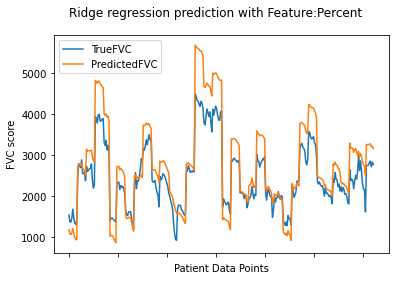

In [44]:
import matplotlib.pyplot as plt # Impot the relevant module

#fig, ax = plt.subplots() # Create the figure and axes object

ax = y_test.plot()
y_pred.plot(ax=ax)
plt.suptitle('Ridge regression prediction with Feature:Percent')
plt.legend(loc="upper left")
plt.xlabel('Patient Data Points')
plt.ylabel('FVC score')
ax.set_xticklabels([])
plt.savefig('foo.png')

# # Plot the first x and y axes:
# df.plot(x = 'year', y = 'deaths', ax = ax) 
# # Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# # (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
# df.plot(x = 'year', y = 'cheese', ax = ax, secondary_y = True) 

In [45]:
s1.shape

(312, 15)

In [46]:
cross_val_score(LinearRegression(),X,y,cv=20,scoring='neg_root_mean_squared_error')
cross_val_score(Ridge(alpha = 0.1),X,y,cv=20,scoring='neg_root_mean_squared_error')

array([-205.1457174 , -200.26314134, -161.74005961, -231.44396432,
       -140.01085211, -167.19945609,  -97.26858906, -188.36372394,
       -152.76554733, -237.67163086, -177.46775183, -192.25153528,
       -197.75684416, -202.35872585, -158.6872219 , -198.34142721,
       -216.283039  , -119.96935512, -193.01618983, -173.4513841 ])

Over predicting/ a more complex needed?